## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


In [3]:
!pip install jellyfish

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [110]:
import pandas as pd
import numpy as np
import time
from pandas_profiling import ProfileReport
from collections import Counter
import matplotlib.pyplot as plt
import jellyfish
import re
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV

## Loading dataset

In [6]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/subs.csv')
data.head(2)

BAN_hashed      IMSI_hashed BRAND DEVICE_MANUFACTURER_TXT MUNICIPALITY_NM  \
0   114717207  906661635071028     T                   Apple          SURREY   
1   112418388  906660952816959     K                 Samsung  PORT COQUITLAM   

  PROVINCE_STATE_CD  TENURE_DAY_QTY_SCALED  \
0                BC               0.013143   
1                BC               0.261786   

                                          PRICE_PLAN  PROD_TV  PROD_INTERNET  \
0  PROMO - Peace of Mind-Unlimited nationwide tal...        1              1   
1                         $45 2GB Unltd min Plan SFD        1              0   

          SEGMENT_NM            LOCALITY_NM            LIFESTAGE  \
0  Metro Melting Pot  Midscale Urban Fringe  Middle-Age Families   
1  Metro Melting Pot  Midscale Urban Fringe  Middle-Age Families   

   THREE_MONTH_AVG_WLN_BILLING_SCALED  THREE_MONTH_AVG_WLS_BILLING_SCALED  
0                            0.022209                            0.052745  
1                            0.029938                            0.095285

## Let's take a first look at the data

In [7]:
profile = ProfileReport(data, title= 'subscriber info', html={'style':{'full_width':True}})

In [8]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Cleaning

In [9]:
## Dropping the BAN_Hashed and IMSI_Hashed columns as they are just client / subscription IDs.

#lookup_data = data[['BAN_hashed', 'IMSI_hashed', 'PRICE_PLAN']]

data = data[['BAN_hashed', 'IMSI_hashed',
        'BRAND', 'DEVICE_MANUFACTURER_TXT',
       'MUNICIPALITY_NM', 'PROVINCE_STATE_CD', 'TENURE_DAY_QTY_SCALED',
       'PRICE_PLAN', 'PROD_TV', 'PROD_INTERNET', 'SEGMENT_NM', 'LOCALITY_NM',
       'LIFESTAGE', 'THREE_MONTH_AVG_WLN_BILLING_SCALED',
       'THREE_MONTH_AVG_WLS_BILLING_SCALED']]

In [10]:
no_internet = data[data['PROD_INTERNET'] == 0]

In [11]:
## For clustering we will only focus on the customers who already have internet

data = data[data['PROD_INTERNET'] == 1]

## Check for missing values

In [12]:
def count_missing(df):
  """
  Given a dataframe, outputs the number of missing values seen in each column and datatype of each column
  """

  columns = list(df.columns)
  count_missing = []
  datatype = []

  for column in columns:
    count_missing.append(df[column].isna().sum())
    datatype.append(type(df[column][0]))

  return pd.DataFrame(list(zip(columns, count_missing, datatype)), columns = ['column', 'count_missing', 'datatype'])


In [13]:
print(count_missing(data))

                                column  count_missing                 datatype
0                           BAN_hashed              0    <class 'numpy.int64'>
1                          IMSI_hashed              0    <class 'numpy.int64'>
2                                BRAND              0            <class 'str'>
3              DEVICE_MANUFACTURER_TXT             13            <class 'str'>
4                      MUNICIPALITY_NM              0            <class 'str'>
5                    PROVINCE_STATE_CD              1            <class 'str'>
6                TENURE_DAY_QTY_SCALED              0  <class 'numpy.float64'>
7                           PRICE_PLAN              0            <class 'str'>
8                              PROD_TV              0    <class 'numpy.int64'>
9                        PROD_INTERNET              0    <class 'numpy.int64'>
10                          SEGMENT_NM              0            <class 'str'>
11                         LOCALITY_NM              

In [14]:
cat_col_with_nan = ['DEVICE_MANUFACTURER_TXT', 'PROVINCE_STATE_CD']

In [15]:
data[data['THREE_MONTH_AVG_WLN_BILLING_SCALED'].isna()].head(3)

BAN_hashed      IMSI_hashed BRAND DEVICE_MANUFACTURER_TXT  \
46     99085563  906660934724406     K                 Samsung   
228   115223994  906660123923808     T                 SAMSUNG   
249   104793459  906660123305568     T                 SAMSUNG   

     MUNICIPALITY_NM PROVINCE_STATE_CD  TENURE_DAY_QTY_SCALED  \
46           KELOWNA                BC               0.114571   
228           SURREY                BC               0.009571   
249  NEW WESTMINSTER                BC               0.020143   

                                            PRICE_PLAN  PROD_TV  \
46                           $40 500MB 500min Plan SFD        1   
228  PROMO - Peace of Mind-Unlimited nationwide tal...        0   
249  Peace of Mind - Unlimited nationwide talk, tex...        1   

     PROD_INTERNET         SEGMENT_NM            LOCALITY_NM  \
46               1       Silver Flats         Older Suburban   
228              1  Metro Melting Pot  Midscale Urban Fringe   
249              1  Social Networkers       Young Urban Core   

                        LIFESTAGE  THREE_MONTH_AVG_WLN_BILLING_SCALED  \
46       Mature Singles & Couples                                 NaN   
228           Middle-Age Families                                 NaN   
249  Very Young Singles & Couples                                 NaN   

     THREE_MONTH_AVG_WLS_BILLING_SCALED  
46                             0.019168  
228                            0.040944  
249                            0.124590

In [16]:
data[data['THREE_MONTH_AVG_WLS_BILLING_SCALED'].isna()].head(3)

BAN_hashed      IMSI_hashed BRAND DEVICE_MANUFACTURER_TXT  \
174    89367162  906661631155878     T                   Apple   
622    81436632  906660121709415     T                   APPLE   
651    53632770  906661629160290     T                 Samsung   

    MUNICIPALITY_NM PROVINCE_STATE_CD  TENURE_DAY_QTY_SCALED     PRICE_PLAN  \
174         BURNABY                BC               0.239571  TELUS Prepaid   
622        VICTORIA                BC               0.205357  TELUS Prepaid   
651        EDMONTON                AB               0.319214     Pay & Talk   

     PROD_TV  PROD_INTERNET          SEGMENT_NM       LOCALITY_NM  \
174        1              1  On Their Own Again       Urban Older   
622        0              1          Indieville  Young Urban Core   
651        0              1          Indieville  Young Urban Core   

                     LIFESTAGE  THREE_MONTH_AVG_WLN_BILLING_SCALED  \
174   Mature Singles & Couples                            0.032649   
622  Younger Singles & Couples                            0.021211   
651  Younger Singles & Couples                            0.028862   

     THREE_MONTH_AVG_WLS_BILLING_SCALED  
174                                 NaN  
622                                 NaN  
651                                 NaN

Above indicates that there are two categorical columns and two float columns that have missing values. Imputation for columns is done in the following scheme:

1. DEVICE_MANUFACTURER_TXT and PROVINCE_STATE_CD : use mode to impute missing values

2. THREE_MONTH_AVG_WLN_BILLING_SCALED and THREE_MONTH_AVG_WLS_BILLING_SCALED : replace NaN with zero. ( Customer might have NaN cause they don't have wireless or home services.

In [17]:
# initialize imputer
imputer = SimpleImputer(strategy='most_frequent')

# fit the imputer on data, save the imputer for later during inferencing step
imputer.fit(data[cat_col_with_nan])

data[cat_col_with_nan] = imputer.transform(data[cat_col_with_nan])

In [18]:
# Replace NaN with zero in numeric columns
data = data.fillna(0)
print(count_missing(data))

                                column  count_missing                 datatype
0                           BAN_hashed              0    <class 'numpy.int64'>
1                          IMSI_hashed              0    <class 'numpy.int64'>
2                                BRAND              0            <class 'str'>
3              DEVICE_MANUFACTURER_TXT              0            <class 'str'>
4                      MUNICIPALITY_NM              0            <class 'str'>
5                    PROVINCE_STATE_CD              0            <class 'str'>
6                TENURE_DAY_QTY_SCALED              0  <class 'numpy.float64'>
7                           PRICE_PLAN              0            <class 'str'>
8                              PROD_TV              0    <class 'numpy.int64'>
9                        PROD_INTERNET              0    <class 'numpy.int64'>
10                          SEGMENT_NM              0            <class 'str'>
11                         LOCALITY_NM              

In [19]:
convert_dict = {
    'BRAND' : str,
    'DEVICE_MANUFACTURER_TXT' : str,
    'MUNICIPALITY_NM' : str, 
    'PROVINCE_STATE_CD' : str,
    'TENURE_DAY_QTY_SCALED' : int,
    'PRICE_PLAN' : str,
    'PROD_TV' : int,
    'PROD_INTERNET' : int,
    'SEGMENT_NM' : str,
    'LOCALITY_NM' : str,
    'LIFESTAGE' : str,
    'THREE_MONTH_AVG_WLN_BILLING_SCALED' : int,
    'THREE_MONTH_AVG_WLS_BILLING_SCALED' : int 
}

data = data.astype(convert_dict)

## Categorical Variables text preprocessing and Encoding

In [20]:
# lower case all text in the dataframe
for column in ['BRAND', 'DEVICE_MANUFACTURER_TXT',
       'MUNICIPALITY_NM', 'PROVINCE_STATE_CD',
       'PRICE_PLAN', 'SEGMENT_NM', 'LOCALITY_NM',
       'LIFESTAGE']:

       data[column] = data[column].str.lower()
       data[column] = data[column].str.replace('[^\w\s]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [21]:
# The price plan feature can't be directly converted into categories as the text is not uniform and needs significant cleaning to form categories.

In [22]:
## Check the cardinality of each column

for column in ['BRAND', 'DEVICE_MANUFACTURER_TXT',
       'MUNICIPALITY_NM', 'PROVINCE_STATE_CD',
        'SEGMENT_NM', 'LOCALITY_NM',
       'LIFESTAGE']:
       print(column, len(set(data[column])))
       print(set(data[column]))

BRAND 2
{'k', 't'}
DEVICE_MANUFACTURER_TXT 36
{'coolpad', 'maxwest', 'blackberry', 'blu', 'samsung', 'microsoft', 'unknown', 'nokia', 'huawei', 'xiaomi', 'razer phone', 'oppo', 'motorola', 'cat', 'sony', 'sonim', 'novatel', 'unihertz', 'realme', 'oneplus', 'google', 'asus', 'redmi', 'htc', 'alcatel', 'zte', 'apple', 'telit', 'kyocera', 'netgear', 'lg', 'poco', 'doogee', 'umidigi', 'sierra', 'alcatel  tcl'}
MUNICIPALITY_NM 849
{'mannville', 'stavely', 'grindrod', 'lagdon', 'ponoka', 'thornhill', 'guy', 'myrnam', 'cherry grove', 'metiskow', 'provost', 'chetwynd', 'bragg creek', 'camrose', 'coldstream', 'fredericton', 'marythorpe', 'fort kent', '100 mile house', 'gunn', 'ryley', 'mount currie', 'rimbey', 'harrogate', 'new denver', 'bakerville', 'windsor', 'vanderhoof', 'houston', 'gitanmaax', 'fort mcmurrat', 'aldersyde', 'peace river regional district', 'millet', 'magrath', 'red deer', 'gabriola island', 'arrowwood', 'pincher creek', 'qualicum beach', 'trail', 'rocky view county', 'cecil

In [23]:
#Since some categorical features have high cardinality, we will use binary encoding instead of OHE
binary_encoder = ce.BinaryEncoder(cols=['BRAND', 'DEVICE_MANUFACTURER_TXT',
       'MUNICIPALITY_NM', 'PROVINCE_STATE_CD',
        'SEGMENT_NM', 'LOCALITY_NM',
       'LIFESTAGE'],return_df=True)
data  = binary_encoder.fit_transform(data) 

In [24]:
# Encoding will replace old columns with new encoding scheme
data.columns

Index(['BAN_hashed', 'IMSI_hashed', 'BRAND_0', 'BRAND_1',
       'DEVICE_MANUFACTURER_TXT_0', 'DEVICE_MANUFACTURER_TXT_1',
       'DEVICE_MANUFACTURER_TXT_2', 'DEVICE_MANUFACTURER_TXT_3',
       'DEVICE_MANUFACTURER_TXT_4', 'DEVICE_MANUFACTURER_TXT_5',
       'MUNICIPALITY_NM_0', 'MUNICIPALITY_NM_1', 'MUNICIPALITY_NM_2',
       'MUNICIPALITY_NM_3', 'MUNICIPALITY_NM_4', 'MUNICIPALITY_NM_5',
       'MUNICIPALITY_NM_6', 'MUNICIPALITY_NM_7', 'MUNICIPALITY_NM_8',
       'MUNICIPALITY_NM_9', 'PROVINCE_STATE_CD_0', 'PROVINCE_STATE_CD_1',
       'PROVINCE_STATE_CD_2', 'PROVINCE_STATE_CD_3', 'TENURE_DAY_QTY_SCALED',
       'PRICE_PLAN', 'PROD_TV', 'PROD_INTERNET', 'SEGMENT_NM_0',
       'SEGMENT_NM_1', 'SEGMENT_NM_2', 'SEGMENT_NM_3', 'SEGMENT_NM_4',
       'SEGMENT_NM_5', 'LOCALITY_NM_0', 'LOCALITY_NM_1', 'LOCALITY_NM_2',
       'LOCALITY_NM_3', 'LOCALITY_NM_4', 'LIFESTAGE_0', 'LIFESTAGE_1',
       'LIFESTAGE_2', 'LIFESTAGE_3', 'THREE_MONTH_AVG_WLN_BILLING_SCALED',
       'THREE_MONTH_AVG_WLS_B

## Feature Scaling for numeric features (Already done with the dataset provided)



## PCA

Before doing PCA we will drop:
- price plan : free form text feature not suitable for PCA
- BAN_hashed and IMSI_hashed : since these are IDs , no need to include them in clustering.

In [25]:
pca_data = data[['BRAND_0', 'BRAND_1',
       'DEVICE_MANUFACTURER_TXT_0', 'DEVICE_MANUFACTURER_TXT_1',
       'DEVICE_MANUFACTURER_TXT_2', 'DEVICE_MANUFACTURER_TXT_3',
       'DEVICE_MANUFACTURER_TXT_4', 'DEVICE_MANUFACTURER_TXT_5',
       'MUNICIPALITY_NM_0', 'MUNICIPALITY_NM_1', 'MUNICIPALITY_NM_2',
       'MUNICIPALITY_NM_3', 'MUNICIPALITY_NM_4', 'MUNICIPALITY_NM_5',
       'MUNICIPALITY_NM_6', 'MUNICIPALITY_NM_7', 'MUNICIPALITY_NM_8',
       'MUNICIPALITY_NM_9', 'PROVINCE_STATE_CD_0', 'PROVINCE_STATE_CD_1',
       'PROVINCE_STATE_CD_2', 'PROVINCE_STATE_CD_3', 'TENURE_DAY_QTY_SCALED',
       'PROD_TV', 'PROD_INTERNET', 'SEGMENT_NM_0',
       'SEGMENT_NM_1', 'SEGMENT_NM_2', 'SEGMENT_NM_3', 'SEGMENT_NM_4',
       'SEGMENT_NM_5', 'LOCALITY_NM_0', 'LOCALITY_NM_1', 'LOCALITY_NM_2',
       'LOCALITY_NM_3', 'LOCALITY_NM_4', 'LIFESTAGE_0', 'LIFESTAGE_1',
       'LIFESTAGE_2', 'LIFESTAGE_3', 'THREE_MONTH_AVG_WLN_BILLING_SCALED',
       'THREE_MONTH_AVG_WLS_BILLING_SCALED']]

lookup_data = data[['BAN_hashed', 'IMSI_hashed','PRICE_PLAN']]

In [26]:
pca_data.shape

(12259, 42)

In [27]:
pca = PCA()
# fit transform
pca_transform = pca.fit_transform(pca_data)

# store the transformed data with lookup data
lookup_data['pca'] = list(pca_transform)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
# Investigate the variance accounted for by each principal component.
variance = pca.explained_variance_ratio_

cumsum_variance=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

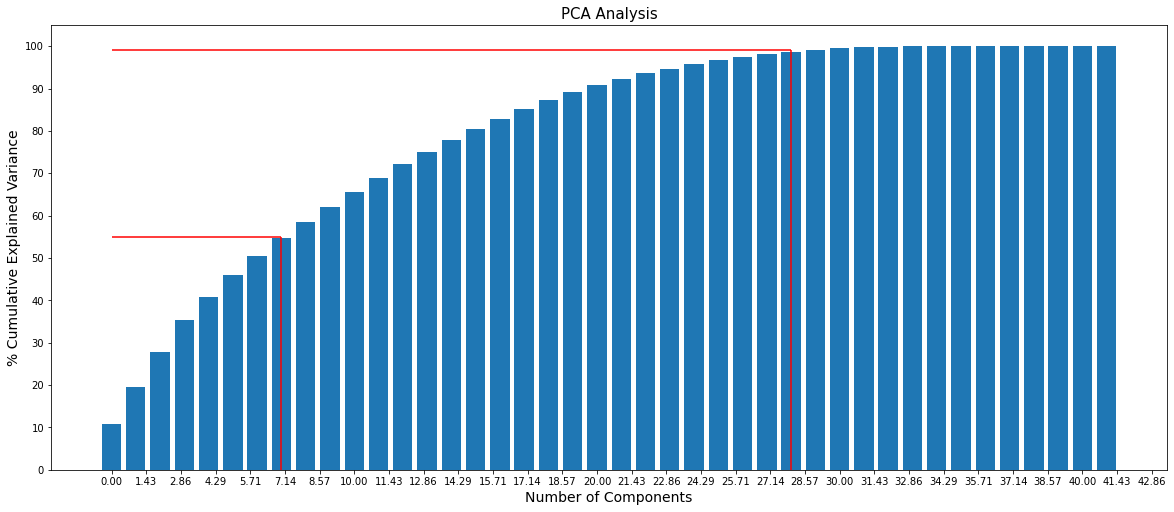

In [29]:
n_components = len(pca.explained_variance_ratio_)
index = np.arange(n_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(20,18))
plt.subplot(2, 1, 1)
plt.bar(index, cumsum_variance)
plt.ylabel('% Cumulative Explained Variance', fontsize = 14)
plt.xlabel('Number of Components', fontsize = 14)
plt.xticks(np.linspace(0,50, 35, endpoint=False))
plt.yticks(np.linspace(0,110, 11, endpoint=False))
plt.title('PCA Analysis', fontsize = 15)


# # 80 components
plt.hlines(y=55, xmin=0, xmax=7, color='red', linestyles='-',zorder=1)
plt.vlines(x=7, ymin=0, ymax=55, color='red', linestyles='-',zorder=2)

# # 240 components
plt.hlines(y=99, xmin=0, xmax=28, color='red', linestyles='-',zorder=3)
plt.vlines(x=28, ymin=0, ymax=99, color='red', linestyles='-',zorder=4)


In [30]:
n_components = 28
print(f'{n_components} has a cumulative explained variane of: {sum(pca.explained_variance_ratio_[:n_components])}')

28 has a cumulative explained variane of: 0.9812703374651276


In [31]:
# re-fit with n components
# apply PCA
pca_28 = PCA(n_components=n_components, random_state= 12)

# fit transform
data_pca_28 = pca_28.fit_transform(pca_data)

After transforming the principle components, now we can check the weight of the each variable on the first few components to see if interpretation is possible.

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

In [32]:
pca_28.explained_variance_ratio_

array([0.10795347, 0.08804867, 0.08116948, 0.07556725, 0.0557067 ,
       0.05198536, 0.04422192, 0.04194151, 0.03807611, 0.03613933,
       0.03449889, 0.03401783, 0.03183575, 0.02967778, 0.02670961,
       0.02636969, 0.02377666, 0.02326357, 0.02226075, 0.01895289,
       0.01577824, 0.01458936, 0.01331694, 0.01144718, 0.01027   ,
       0.0096304 , 0.00763369, 0.00643129])

In [33]:
# Create a dataframe of Explained Variance ratio in pca_237.
dimensions = ['PC_{}'.format(i) for i in range(1,len(pca_28.components_)+1)]
ratios = pca_28.explained_variance_ratio_
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance Ratio'])
variance_ratios.index = dimensions

In [34]:
variance_ratios

Explained Variance Ratio
PC_1                     0.1080
PC_2                     0.0880
PC_3                     0.0812
PC_4                     0.0756
PC_5                     0.0557
PC_6                     0.0520
PC_7                     0.0442
PC_8                     0.0419
PC_9                     0.0381
PC_10                    0.0361
PC_11                    0.0345
PC_12                    0.0340
PC_13                    0.0318
PC_14                    0.0297
PC_15                    0.0267
PC_16                    0.0264
PC_17                    0.0238
PC_18                    0.0233
PC_19                    0.0223
PC_20                    0.0190
PC_21                    0.0158
PC_22                    0.0146
PC_23                    0.0133
PC_24                    0.0114
PC_25                    0.0103
PC_26                    0.0096
PC_27                    0.0076
PC_28                    0.0064

In [35]:
# Create a dataframe with the weights for each principal component in pca_28.
# Map weights for the principal components to corresponding feature names.
components_weights = pd.DataFrame(np.round(pca_28.components_, 4), columns = pca_data.keys())
components_weights.index = dimensions
components_weights.head()

BRAND_0  BRAND_1  DEVICE_MANUFACTURER_TXT_0  DEVICE_MANUFACTURER_TXT_1  \
PC_1  -0.0361   0.0361                     0.0003                     0.0000   
PC_2   0.0477  -0.0477                    -0.0004                     0.0010   
PC_3   0.0949  -0.0949                    -0.0001                     0.0007   
PC_4  -0.0291   0.0291                    -0.0004                     0.0004   
PC_5   0.1872  -0.1872                     0.0003                     0.0035   

      DEVICE_MANUFACTURER_TXT_2  DEVICE_MANUFACTURER_TXT_3  \
PC_1                     0.0236                     0.0061   
PC_2                    -0.0065                     0.0060   
PC_3                    -0.0304                    -0.0049   
PC_4                    -0.0026                    -0.0057   
PC_5                     0.0354                     0.0574   

      DEVICE_MANUFACTURER_TXT_4  DEVICE_MANUFACTURER_TXT_5  MUNICIPALITY_NM_0  \
PC_1                    -0.0054                    -0.0307             0.1030   
PC_2                     0.0127                    -0.0023             0.0134   
PC_3                     0.0268                     0.0201            -0.0493   
PC_4                    -0.0149                     0.0162            -0.1190   
PC_5                     0.6583                    -0.6694             0.0026   

      MUNICIPALITY_NM_1  ...  LOCALITY_NM_1  LOCALITY_NM_2  LOCALITY_NM_3  \
PC_1             0.1022  ...         0.0789         0.0231         0.3960   
PC_2             0.1045  ...        -0.1709         0.1725         0.0336   
PC_3            -0.0804  ...         0.0283        -0.2185        -0.1502   
PC_4            -0.0530  ...         0.4766        -0.2126         0.0906   
PC_5            -0.0104  ...        -0.0001         0.0686        -0.0373   

      LOCALITY_NM_4  LIFESTAGE_0  LIFESTAGE_1  LIFESTAGE_2  LIFESTAGE_3  \
PC_1         0.1125      -0.0691      -0.2996      -0.0479       0.3169   
PC_2         0.1247      -0.1843       0.3411       0.4433      -0.2834   
PC_3        -0.2952       0.2233      -0.1500      -0.2926       0.1323   
PC_4        -0.3343      -0.1838       0.1237      -0.1183      -0.0413   
PC_5         0.0004      -0.0490      -0.0020      -0.0325       0.0514   

      THREE_MONTH_AVG_WLN_BILLING_SCALED  THREE_MONTH_AVG_WLS_BILLING_SCALED  
PC_1                             -0.0000                              0.0002  
PC_2                              0.0001                             -0.0000  
PC_3                             -0.0001                             -0.0002  
PC_4                             -0.0001                             -0.0001  
PC_5                             -0.0001                              0.0002  

[5 rows x 42 columns]

In [36]:

# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Highest positive and negative weights for the first Principal Componnent

def weights_sorted_p_comp(n_p_comp, n_weights):
    p_comp = 'PC' + '_' + str(n_p_comp)
    print("Principal Component", (n_p_comp))
    print('-' * 30)
    print("\nTop positive weights are below\n")
    print(components_weights.loc[p_comp].sort_values(ascending=False)[:n_weights])
    print('-' * 30)
    print("\nTop negative weights are below\n")
    print(components_weights.loc[p_comp].sort_values()[:n_weights])

# Plot the feature weights as a function of the components
def plot_component_weights(n_p_comp, n_weights):
    '''
    n_p_comp: prinicipal component number
    n_weights: number of top positive and top negative weights
    '''
    p_comp = 'PC' + '_' + str(n_p_comp)
    comp_weight_first_last = components_weights.loc[p_comp].sort_values(ascending=False)[:n_weights].append(
                                    components_weights.loc[p_comp].sort_values()[:n_weights])
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (10,6))
    comp_weight_first_last.plot(ax = ax, kind = 'barh')

    # Turn on the grid
    ax.grid()
    
    # Don't allow the axis to be on top of your data
    ax.set_axisbelow(True)
    
    # Customize the grid
    ax.grid(linewidth='0.5', alpha=0.5)

    #comp_weight_first_last.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights")
    #ax.set_xticklabels(list(comp_weight_first_last.index), rotation='vertical')
    plt.show()
    
# Getting top 5 positive and negative weights of a principal component 1.
weights_sorted_p_comp(1, 5)

Principal Component 1
------------------------------

Top positive weights are below

LOCALITY_NM_3        0.3960
LIFESTAGE_3          0.3169
MUNICIPALITY_NM_4    0.2831
MUNICIPALITY_NM_7    0.2490
MUNICIPALITY_NM_3    0.2347
Name: PC_1, dtype: float64
------------------------------

Top negative weights are below

SEGMENT_NM_1          -0.3372
LIFESTAGE_1           -0.2996
MUNICIPALITY_NM_5     -0.1969
PROD_TV               -0.1596
PROVINCE_STATE_CD_2   -0.1531
Name: PC_1, dtype: float64


## Clustering eixsiting internet customers


In [37]:
#Function to identify scores for each kmeans model by different centroids
SEED = 12
def get_Kmeans_scores(data, K_start, K_end, step=1):
    
    scores = []
    
    print("Performing K-Means clustering")
    print("Given range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("\nTraining for n_clusters: ", n)
        start = time.time()
        
        kmeans = KMeans(n, random_state=SEED)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("Done! Score: ", scores[-1])
        print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return scores, range(K_start, K_end+1, step)

In [38]:
scores, range_ = get_Kmeans_scores(data_pca_28, 2, 60, 1)

Performing K-Means clustering
Given range min:2, max:60, step:1

Training for n_clusters:  2
Done! Score:  75688.48395243392
Time elapsed: 0.52 sec.

Training for n_clusters:  3
Done! Score:  70493.78934728069
Time elapsed: 0.51 sec.

Training for n_clusters:  4
Done! Score:  66356.21824238409
Time elapsed: 0.75 sec.

Training for n_clusters:  5
Done! Score:  63366.31784785741
Time elapsed: 0.61 sec.

Training for n_clusters:  6
Done! Score:  61503.303995946946
Time elapsed: 0.57 sec.

Training for n_clusters:  7
Done! Score:  59820.98513277013
Time elapsed: 1.14 sec.

Training for n_clusters:  8
Done! Score:  58152.302996659666
Time elapsed: 0.89 sec.

Training for n_clusters:  9
Done! Score:  56810.774586522195
Time elapsed: 0.94 sec.

Training for n_clusters:  10
Done! Score:  55067.99736471668
Time elapsed: 0.92 sec.

Training for n_clusters:  11
Done! Score:  54475.902247259786
Time elapsed: 0.96 sec.

Training for n_clusters:  12
Done! Score:  52994.83552234758
Time elapsed: 2.35

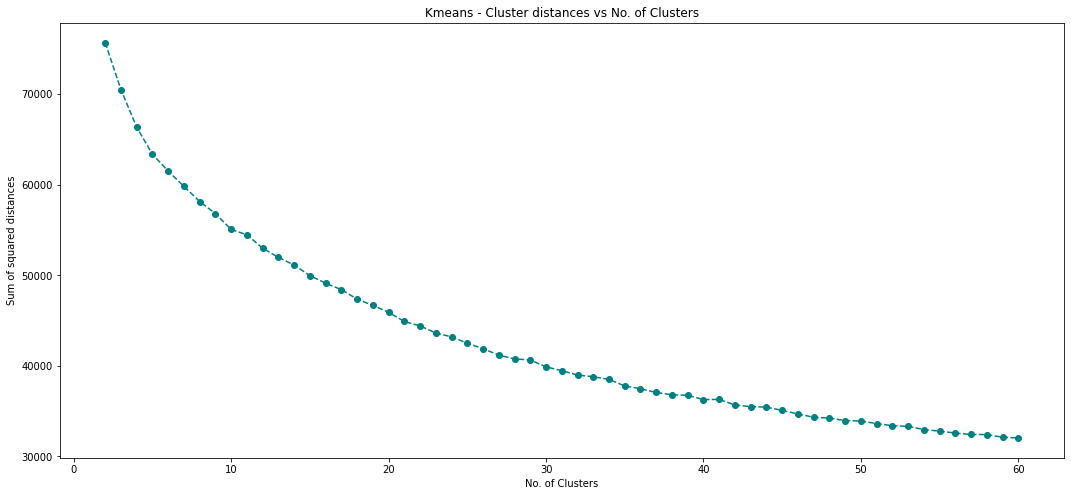

In [39]:
def plot_elbow(scores, range_):
    
    fig = plt.figure(figsize=(18,8))
    ax = fig.add_subplot(111)
    
    ax.plot(range_, scores, linestyle= "--",marker = "o", color="teal")
    ax.set_xlabel("No. of Clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances vs No. of Clusters")
    
    plt.show()
plot_elbow(scores, range_)

The idea behind the elbow method, is that the number of clusters can be selected in such a way that adding one more cluster to the existing clusters will not improve the intra-cluster variation. Which means adding a cluster will not reduce the sum of sqaured distances between the clusters.

From the elbow above, we can see that the sum of sqaured error decreasing with a high slope until around 25 clusters and then the slope decreases.

In [40]:
#Fit the model specifying the 7 clusters
kmeans_25 = KMeans(25, random_state=SEED)

model_25 = kmeans_25.fit(data_pca_28)


#Make predictions
data_clusters_preds = model_25.predict(data_pca_28)


In [41]:
lookup_data['cluster_number'] = data_clusters_preds
lookup_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


BAN_hashed      IMSI_hashed  \
0       114717207  906661635071028   
5       104272857  906660105079509   
6       104895696  906660937397472   
7       115360617  906660954695775   
9        47952417  906661636227330   
...           ...              ...   
19990   110329869  906660121557795   
19993   110108865  906660121891302   
19996    94550520  906660916136193   
19997    28316730  906661629631422   
19999   116320722  906660125040144   

                                              PRICE_PLAN  \
0      promo  peace of mindunlimited nationwide talk ...   
5      simple share 10  unlimited nationwide talk tex...   
6                                45 2gb 500 min plan sfd   
7      peace of mind  unlimited nationwide talk text ...   
9      peace of mind  unlimited nationwide talk text ...   
...                                                  ...   
19990  peace of mind  unlimited nationwide talk text ...   
19993  peace of mind  unlimited nationwide talk text ...   
19996                             55 8gb ul min plan sfd   
19997  4gb standard 70  unlimited nationwide talk and...   
19999  unlimited 20  unlimited nationwide talk text a...   

                                                     pca  cluster_number  
0      [-0.17962183663652773, 0.270509637370543, 0.75...              23  
5      [0.18555747365288655, 0.9283491815024788, 0.67...               2  
6      [-0.2518596689471395, 0.3659436706387146, 0.94...              23  
7      [-0.15431728169314238, 0.28555848820784263, 0....              23  
9      [-0.019268726102860418, 0.012686361068740973, ...               8  
...                                                  ...             ...  
19990  [-0.6696229624090132, -1.1615707241035502, 0.2...               6  
19993  [-0.34899112030870855, -0.26413443094198885, 1...              23  
19996  [-0.44653350756269217, -0.18374924851110694, 1...              23  
19997  [-0.3489911203087083, -0.2641344309419891, 1.5...              23  
19999  [-0.7163697882514616, -1.2378384701281284, 0.2...               6  

[12259 rows x 5 columns]

In [42]:
# Total number of unique clusters in sample general population data
np.unique(data_clusters_preds)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24], dtype=int32)

In [43]:
# Distribution of general population sample data in clusters
pd.Series(data_clusters_preds).value_counts().sort_index()
df = pd.Series(data_clusters_preds).value_counts().sort_index().to_frame()
df['cluster_number'] = df.index
df.reset_index(drop=True, inplace=True)
clustered_internet_customers = df.rename(columns = {0: 'num_customers'})
clustered_internet_customers

num_customers  cluster_number
0             640               0
1             614               1
2             514               2
3             698               3
4             527               4
5             635               5
6             645               6
7             414               7
8             361               8
9             498               9
10            455              10
11            586              11
12            607              12
13            385              13
14            477              14
15            479              15
16            353              16
17            215              17
18            397              18
19            625              19
20            289              20
21            550              21
22            344              22
23            439              23
24            512              24

In [44]:
sorted_clustered_internet_customers = clustered_internet_customers.sort_values('num_customers', ascending=False)
sorted_clustered_internet_customers

num_customers  cluster_number
3             698               3
6             645               6
0             640               0
5             635               5
19            625              19
1             614               1
12            607              12
11            586              11
21            550              21
4             527               4
2             514               2
24            512              24
9             498               9
15            479              15
14            477              14
10            455              10
23            439              23
7             414               7
18            397              18
13            385              13
8             361               8
16            353              16
22            344              22
20            289              20
17            215              17

In [45]:
tot_internet_customers = len(data_pca_28)
top_20_percent = int(tot_internet_customers * 0.20)
top_20_percent

2451

In [46]:
sorted_clustered_internet_customers['cumsum_customers'] = sorted_clustered_internet_customers['num_customers'].cumsum()
sorted_clustered_internet_customers

num_customers  cluster_number  cumsum_customers
3             698               3               698
6             645               6              1343
0             640               0              1983
5             635               5              2618
19            625              19              3243
1             614               1              3857
12            607              12              4464
11            586              11              5050
21            550              21              5600
4             527               4              6127
2             514               2              6641
24            512              24              7153
9             498               9              7651
15            479              15              8130
14            477              14              8607
10            455              10              9062
23            439              23              9501
7             414               7              9915
18            397              18             10312
13            385              13             10697
8             361               8             11058
16            353              16             11411
22            344              22             11755
20            289              20             12044
17            215              17             12259

### Therefore to start with we need to target new customers which fall into clusters [3,6,0,5] because they are the largest user groups/clusters and also account for 20% of all internet customers. 

### So for existing base of mobility customers without internet, we should first start targeting the people who fall into the above clusters and then later focus on customer who fall into other clusters.

## Feature Engg on price plan for internet customers in top clusters

In [47]:
lookup_data.head(3)

BAN_hashed      IMSI_hashed  \
0   114717207  906661635071028   
5   104272857  906660105079509   
6   104895696  906660937397472   

                                          PRICE_PLAN  \
0  promo  peace of mindunlimited nationwide talk ...   
5  simple share 10  unlimited nationwide talk tex...   
6                            45 2gb 500 min plan sfd   

                                                 pca  cluster_number  
0  [-0.17962183663652773, 0.270509637370543, 0.75...              23  
5  [0.18555747365288655, 0.9283491815024788, 0.67...               2  
6  [-0.2518596689471395, 0.3659436706387146, 0.94...              23

In [48]:
## Only focus on those in clusters [3,6,0,5]
top_clusters = [3,6,0,5]
top_internet_customers = lookup_data[lookup_data.cluster_number.isin(top_clusters)]
top_internet_customers

BAN_hashed      IMSI_hashed  \
30       57161310  906661629526443   
46       99085563  906660934724406   
56       52924164  906660916159587   
63       92155011  906661635278313   
69        7124682  906660033911310   
...           ...              ...   
19977    23804442  906661634275410   
19981    69573804  906660045909579   
19989    65844099  906660047907291   
19990   110329869  906660121557795   
19999   116320722  906660125040144   

                                              PRICE_PLAN  \
30     peace of mind  unlimited nationwide talk text ...   
46                              40 500mb 500min plan sfd   
56                                     25 100 local plan   
63     peace of mind  unlimited nationwide talk text ...   
69                            lr ulnw 6gb shareable data   
...                                                  ...   
19977                          wireless internet 100  gf   
19981  peace of mind  unlimited nationwide talk text ...   
19989  peace of mind  unlimited nationwide talk text ...   
19990  peace of mind  unlimited nationwide talk text ...   
19999  unlimited 20  unlimited nationwide talk text a...   

                                                     pca  cluster_number  
30     [0.08593216307400245, 0.8187559413742725, 0.14...               5  
46     [0.5747691901758518, 0.9714891371519354, 0.684...               0  
56     [0.48959917452456797, 1.0822007392937203, 0.82...               0  
63     [0.22654499031549807, 0.9588799383343681, 0.05...               5  
69     [-0.4271380620572184, -0.9107291025930004, -0....               6  
...                                                  ...             ...  
19977  [-0.662010002151047, -1.24197474325876, 0.1503...               6  
19981  [-0.6696229624090132, -1.1615707241035502, 0.2...               6  
19989  [-0.8506438663447494, -1.208512099248991, 0.47...               6  
19990  [-0.6696229624090132, -1.1615707241035502, 0.2...               6  
19999  [-0.7163697882514616, -1.2378384701281284, 0.2...               6  

[2618 rows x 5 columns]

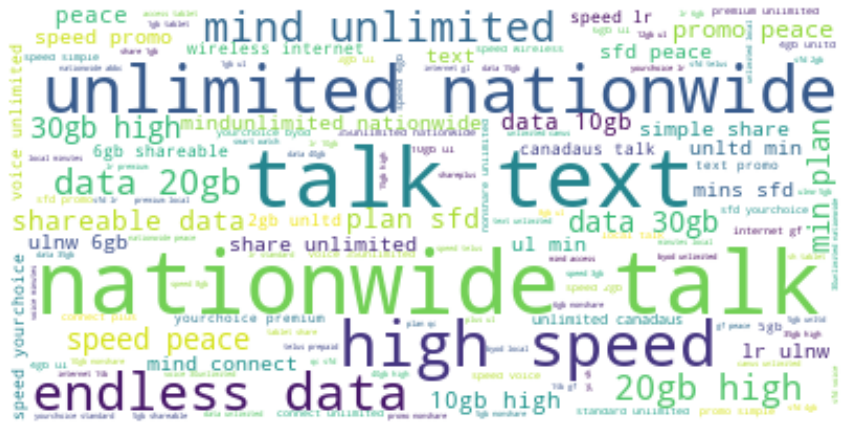

In [49]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

text = " ".join(i for i in top_internet_customers.PRICE_PLAN)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [66]:
def create_features(df):

  """
  Given df with price plan column , extract information about number of GB internet found in the plan description,
  if non found returns 0.
  """

  qty_internet = []

  for plan in df['PRICE_PLAN']:
    plan = plan.lower()
    try:
      internet = re.search("(\d*\s*(gb|mb|g))", plan)
      qty_internet.append(str(internet))
      
    except:
      qty_internet.append(0)

  df['num_gb'] = qty_internet
  return df


In [67]:
top_internet_customers = create_features(top_internet_customers)
top_internet_customers.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


BAN_hashed      IMSI_hashed  \
30    57161310  906661629526443   
46    99085563  906660934724406   
56    52924164  906660916159587   

                                           PRICE_PLAN  \
30  peace of mind  unlimited nationwide talk text ...   
46                           40 500mb 500min plan sfd   
56                                  25 100 local plan   

                                                  pca  cluster_number  \
30  [0.08593216307400245, 0.8187559413742725, 0.14...               5   
46  [0.5747691901758518, 0.9714891371519354, 0.684...               0   
56  [0.48959917452456797, 1.0822007392937203, 0.82...               0   

                                            num_gb  
30  <re.Match object; span=(63, 67), match='20gb'>  
46   <re.Match object; span=(3, 8), match='500mb'>  
56                                            None

## Clustering data for mobility customers without internet

In [68]:
no_internet.head(3)

BAN_hashed      IMSI_hashed BRAND DEVICE_MANUFACTURER_TXT MUNICIPALITY_NM  \
1   112418388  906660952816959     K                 Samsung  PORT COQUITLAM   
2    53146188  906660062171958     T                   Apple        EDMONTON   
3    30467094  906660089430135     T                 Samsung         CALGARY   

  PROVINCE_STATE_CD  TENURE_DAY_QTY_SCALED  \
1                BC               0.261786   
2                AB               0.321214   
3                AB               0.415714   

                                          PRICE_PLAN  PROD_TV  PROD_INTERNET  \
1                         $45 2GB Unltd min Plan SFD        1              0   
2  Peace of Mind - Unlimited nationwide talk, tex...        1              0   
3                        L&R ULNW 5GB shareable data        1              0   

          SEGMENT_NM            LOCALITY_NM                     LIFESTAGE  \
1  Metro Melting Pot  Midscale Urban Fringe           Middle-Age Families   
2  Social Networkers       Young Urban Core  Very Young Singles & Couples   
3  Social Networkers       Young Urban Core  Very Young Singles & Couples   

   THREE_MONTH_AVG_WLN_BILLING_SCALED  THREE_MONTH_AVG_WLS_BILLING_SCALED  
1                            0.029938                            0.095285  
2                            0.021639                            0.047167  
3                            0.017315                            0.026276

In [70]:
## Applying all pre-processing steps:

# Imputation, data cleaning, encoding, pca


In [69]:
no_internet[cat_col_with_nan] = imputer.transform(no_internet[cat_col_with_nan])
no_internet = no_internet.fillna(0)

In [71]:
for column in ['BRAND', 'DEVICE_MANUFACTURER_TXT',
       'MUNICIPALITY_NM', 'PROVINCE_STATE_CD',
       'PRICE_PLAN', 'SEGMENT_NM', 'LOCALITY_NM',
       'LIFESTAGE']:

       no_internet[column] = no_internet[column].str.lower()
       no_internet[column] = no_internet[column].str.replace('[^\w\s]','')


no_internet  = binary_encoder.transform(no_internet) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [72]:
no_internet.columns

Index(['BAN_hashed', 'IMSI_hashed', 'BRAND_0', 'BRAND_1',
       'DEVICE_MANUFACTURER_TXT_0', 'DEVICE_MANUFACTURER_TXT_1',
       'DEVICE_MANUFACTURER_TXT_2', 'DEVICE_MANUFACTURER_TXT_3',
       'DEVICE_MANUFACTURER_TXT_4', 'DEVICE_MANUFACTURER_TXT_5',
       'MUNICIPALITY_NM_0', 'MUNICIPALITY_NM_1', 'MUNICIPALITY_NM_2',
       'MUNICIPALITY_NM_3', 'MUNICIPALITY_NM_4', 'MUNICIPALITY_NM_5',
       'MUNICIPALITY_NM_6', 'MUNICIPALITY_NM_7', 'MUNICIPALITY_NM_8',
       'MUNICIPALITY_NM_9', 'PROVINCE_STATE_CD_0', 'PROVINCE_STATE_CD_1',
       'PROVINCE_STATE_CD_2', 'PROVINCE_STATE_CD_3', 'TENURE_DAY_QTY_SCALED',
       'PRICE_PLAN', 'PROD_TV', 'PROD_INTERNET', 'SEGMENT_NM_0',
       'SEGMENT_NM_1', 'SEGMENT_NM_2', 'SEGMENT_NM_3', 'SEGMENT_NM_4',
       'SEGMENT_NM_5', 'LOCALITY_NM_0', 'LOCALITY_NM_1', 'LOCALITY_NM_2',
       'LOCALITY_NM_3', 'LOCALITY_NM_4', 'LIFESTAGE_0', 'LIFESTAGE_1',
       'LIFESTAGE_2', 'LIFESTAGE_3', 'THREE_MONTH_AVG_WLN_BILLING_SCALED',
       'THREE_MONTH_AVG_WLS_B

In [78]:
no_internet_pca = no_internet[[ 'BRAND_0', 'BRAND_1',
       'DEVICE_MANUFACTURER_TXT_0', 'DEVICE_MANUFACTURER_TXT_1',
       'DEVICE_MANUFACTURER_TXT_2', 'DEVICE_MANUFACTURER_TXT_3',
       'DEVICE_MANUFACTURER_TXT_4', 'DEVICE_MANUFACTURER_TXT_5',
       'MUNICIPALITY_NM_0', 'MUNICIPALITY_NM_1', 'MUNICIPALITY_NM_2',
       'MUNICIPALITY_NM_3', 'MUNICIPALITY_NM_4', 'MUNICIPALITY_NM_5',
       'MUNICIPALITY_NM_6', 'MUNICIPALITY_NM_7', 'MUNICIPALITY_NM_8',
       'MUNICIPALITY_NM_9', 'PROVINCE_STATE_CD_0', 'PROVINCE_STATE_CD_1',
       'PROVINCE_STATE_CD_2', 'PROVINCE_STATE_CD_3', 'TENURE_DAY_QTY_SCALED',
       'PROD_TV', 'SEGMENT_NM_0', 'PROD_INTERNET',
       'SEGMENT_NM_1', 'SEGMENT_NM_2', 'SEGMENT_NM_3', 'SEGMENT_NM_4',
       'SEGMENT_NM_5', 'LOCALITY_NM_0', 'LOCALITY_NM_1', 'LOCALITY_NM_2',
       'LOCALITY_NM_3', 'LOCALITY_NM_4', 'LIFESTAGE_0', 'LIFESTAGE_1',
       'LIFESTAGE_2', 'LIFESTAGE_3', 'THREE_MONTH_AVG_WLN_BILLING_SCALED',
       'THREE_MONTH_AVG_WLS_BILLING_SCALED']]

no_internet_lookup = no_internet[['BAN_hashed', 'IMSI_hashed', 'PRICE_PLAN']]

In [79]:
no_internet_pca_28 = pca_28.transform(no_internet_pca)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [81]:
predict_customers_clusters = model_25.predict(no_internet_pca_28)

In [82]:
no_internet_lookup['cluster_number'] = predict_customers_clusters
no_internet_lookup.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


BAN_hashed      IMSI_hashed  \
1   112418388  906660952816959   
2    53146188  906660062171958   
3    30467094  906660089430135   

                                          PRICE_PLAN  cluster_number  
1                          45 2gb unltd min plan sfd               0  
2  peace of mind  unlimited nationwide talk text ...               9  
3                         lr ulnw 5gb shareable data               9

In [86]:
target_customers = no_internet_lookup[no_internet_lookup['cluster_number'].isin(top_clusters)]
target_customers.to_csv('/content/drive/MyDrive/Colab Notebooks/targeted_customers_clustering.csv')

In [87]:
target_customers

BAN_hashed      IMSI_hashed  \
1       112418388  906660952816959   
14       73802871  906660120849213   
16       87341085  906660933172968   
19       68772714  906661635951813   
26      104224341  906660951608607   
...           ...              ...   
19976    87736158  906660057253365   
19982   115900239  906660115385709   
19985   109016532  906661636822650   
19991   102175773  906660119695512   
19994    98472366  906661631870148   

                                              PRICE_PLAN  cluster_number  
1                              45 2gb unltd min plan sfd               0  
14     4gb standard 70  nonshare 500 nationwide minut...               0  
16                                50 4gb ul min plan sfd               0  
19     unlimited 30  unlimited nationwide talk text a...               5  
26                                45 1gb ul min plan sfd               6  
...                                                  ...             ...  
19976  peace of mind  unlimited nationwide talk text ...               6  
19982                             45 4gb ul can mins sfd               6  
19985  peace of mind  unlimited nationwide talk text ...               6  
19991  peace of mind  unlimited nationwide talk text ...               6  
19994  peace of mind  unlimited nationwide talk text ...               6  

[1428 rows x 4 columns]

In [ ]:
## Above we reduced the number of no internet customers to be targeted from 7,741 to 1,428 approx 80%  decrease in number of people to be targeted

In [84]:
Counter(target_customers['cluster_number'])

Counter({0: 398, 3: 198, 5: 381, 6: 451})

## Supervised Classifier to predict probability that customer will buy internet after being advertised

In [153]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/subs.csv')

In [154]:
dataset = dataset[['BAN_hashed', 'IMSI_hashed',
        'BRAND', 'DEVICE_MANUFACTURER_TXT',
       'MUNICIPALITY_NM', 'PROVINCE_STATE_CD', 'TENURE_DAY_QTY_SCALED',
       'PRICE_PLAN', 'PROD_TV', 'PROD_INTERNET', 'SEGMENT_NM', 'LOCALITY_NM',
       'LIFESTAGE', 'THREE_MONTH_AVG_WLN_BILLING_SCALED',
       'THREE_MONTH_AVG_WLS_BILLING_SCALED']]

In [155]:
print(count_missing(dataset))

                                column  count_missing                 datatype
0                           BAN_hashed              0    <class 'numpy.int64'>
1                          IMSI_hashed              0    <class 'numpy.int64'>
2                                BRAND              0            <class 'str'>
3              DEVICE_MANUFACTURER_TXT             17            <class 'str'>
4                      MUNICIPALITY_NM              0            <class 'str'>
5                    PROVINCE_STATE_CD              5            <class 'str'>
6                TENURE_DAY_QTY_SCALED              0  <class 'numpy.float64'>
7                           PRICE_PLAN              0            <class 'str'>
8                              PROD_TV              0    <class 'numpy.int64'>
9                        PROD_INTERNET              0    <class 'numpy.int64'>
10                          SEGMENT_NM              0            <class 'str'>
11                         LOCALITY_NM              

In [156]:
for column in ['BRAND', 'DEVICE_MANUFACTURER_TXT',
       'MUNICIPALITY_NM', 'PROVINCE_STATE_CD',
       'PRICE_PLAN', 'SEGMENT_NM', 'LOCALITY_NM',
       'LIFESTAGE']:

       dataset[column] = dataset[column].str.lower()
       dataset[column] = dataset[column].str.replace('[^\w\s]','')

y = dataset['PROD_INTERNET']
dataset.drop('PROD_INTERNET', axis=1, inplace=True)


binary_encoder = ce.BinaryEncoder(cols=['BRAND', 'DEVICE_MANUFACTURER_TXT',
       'MUNICIPALITY_NM', 'PROVINCE_STATE_CD',
        'SEGMENT_NM', 'LOCALITY_NM',
       'LIFESTAGE'],return_df=True)
dataset = binary_encoder.fit_transform(dataset)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [158]:
dataset.columns

Index(['BAN_hashed', 'IMSI_hashed', 'BRAND_0', 'BRAND_1',
       'DEVICE_MANUFACTURER_TXT_0', 'DEVICE_MANUFACTURER_TXT_1',
       'DEVICE_MANUFACTURER_TXT_2', 'DEVICE_MANUFACTURER_TXT_3',
       'DEVICE_MANUFACTURER_TXT_4', 'DEVICE_MANUFACTURER_TXT_5',
       'MUNICIPALITY_NM_0', 'MUNICIPALITY_NM_1', 'MUNICIPALITY_NM_2',
       'MUNICIPALITY_NM_3', 'MUNICIPALITY_NM_4', 'MUNICIPALITY_NM_5',
       'MUNICIPALITY_NM_6', 'MUNICIPALITY_NM_7', 'MUNICIPALITY_NM_8',
       'MUNICIPALITY_NM_9', 'PROVINCE_STATE_CD_0', 'PROVINCE_STATE_CD_1',
       'PROVINCE_STATE_CD_2', 'PROVINCE_STATE_CD_3', 'TENURE_DAY_QTY_SCALED',
       'PRICE_PLAN', 'PROD_TV', 'SEGMENT_NM_0', 'SEGMENT_NM_1', 'SEGMENT_NM_2',
       'SEGMENT_NM_3', 'SEGMENT_NM_4', 'SEGMENT_NM_5', 'LOCALITY_NM_0',
       'LOCALITY_NM_1', 'LOCALITY_NM_2', 'LOCALITY_NM_3', 'LOCALITY_NM_4',
       'LIFESTAGE_0', 'LIFESTAGE_1', 'LIFESTAGE_2', 'LIFESTAGE_3',
       'THREE_MONTH_AVG_WLN_BILLING_SCALED',
       'THREE_MONTH_AVG_WLS_BILLING_SCALED'],


In [159]:
X = dataset[['BRAND_0', 'BRAND_1',
       'DEVICE_MANUFACTURER_TXT_0', 'DEVICE_MANUFACTURER_TXT_1',
       'DEVICE_MANUFACTURER_TXT_2', 'DEVICE_MANUFACTURER_TXT_3',
       'DEVICE_MANUFACTURER_TXT_4', 'DEVICE_MANUFACTURER_TXT_5',
       'MUNICIPALITY_NM_0', 'MUNICIPALITY_NM_1', 'MUNICIPALITY_NM_2',
       'MUNICIPALITY_NM_3', 'MUNICIPALITY_NM_4', 'MUNICIPALITY_NM_5',
       'MUNICIPALITY_NM_6', 'MUNICIPALITY_NM_7', 'MUNICIPALITY_NM_8',
       'MUNICIPALITY_NM_9', 'PROVINCE_STATE_CD_0', 'PROVINCE_STATE_CD_1',
       'PROVINCE_STATE_CD_2', 'PROVINCE_STATE_CD_3', 'TENURE_DAY_QTY_SCALED',
        'PROD_TV', 'SEGMENT_NM_0', 'SEGMENT_NM_1', 'SEGMENT_NM_2',
       'SEGMENT_NM_3', 'SEGMENT_NM_4', 'SEGMENT_NM_5', 'LOCALITY_NM_0',
       'LOCALITY_NM_1', 'LOCALITY_NM_2', 'LOCALITY_NM_3', 'LOCALITY_NM_4',
       'LIFESTAGE_0', 'LIFESTAGE_1', 'LIFESTAGE_2', 'LIFESTAGE_3',
       'THREE_MONTH_AVG_WLN_BILLING_SCALED',
       'THREE_MONTH_AVG_WLS_BILLING_SCALED']]

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [130]:
Counter(y_train)

Counter({0: 5195, 1: 8205})

In [131]:
Counter(y_test)

Counter({0: 2546, 1: 4054})

In [167]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [168]:
lor = LogisticRegression(random_state=42) # LogisticRegression
rfc = RandomForestClassifier(random_state=42) # RandomForestClassifier
abc = AdaBoostClassifier(random_state=42) # AdaBoostClassifier
gbc = GradientBoostingClassifier(random_state=42) # GradientBoostingClassifier

In [169]:
X_train

BRAND_0  BRAND_1  DEVICE_MANUFACTURER_TXT_0  DEVICE_MANUFACTURER_TXT_1  \
7070         0        1                          0                          0   
13010        0        1                          0                          0   
6688         0        1                          0                          0   
9976         0        1                          0                          0   
5175         0        1                          0                          0   
...        ...      ...                        ...                        ...   
11284        0        1                          0                          0   
11964        0        1                          0                          0   
5390         0        1                          0                          0   
860          0        1                          0                          0   
15795        0        1                          0                          0   

       DEVICE_MANUFACTURER_TXT_2  DEVICE_MANUFACTURER_TXT_3  \
7070                           0                          0   
13010                          0                          0   
6688                           0                          0   
9976                           0                          0   
5175                           0                          0   
...                          ...                        ...   
11284                          0                          0   
11964                          0                          0   
5390                           0                          0   
860                            0                          0   
15795                          0                          0   

       DEVICE_MANUFACTURER_TXT_4  DEVICE_MANUFACTURER_TXT_5  \
7070                           0                          1   
13010                          1                          0   
6688                           1                          0   
9976                           0                          1   
5175                           0                          1   
...                          ...                        ...   
11284                          1                          0   
11964                          0                          1   
5390                           0                          1   
860                            0                          1   
15795                          0                          1   

       MUNICIPALITY_NM_0  MUNICIPALITY_NM_1  ...  LOCALITY_NM_1  \
7070                   0                  0  ...              1   
13010                  1                  0  ...              1   
6688                   0                  0  ...              0   
9976                   0                  0  ...              1   
5175                   0                  1  ...              1   
...                  ...                ...  ...            ...   
11284                  0                  0  ...              1   
11964                  0                  0  ...              0   
5390                   0                  0  ...              1   
860                    0                  0  ...              1   
15795                  0                  0  ...              0   

       LOCALITY_NM_2  LOCALITY_NM_3  LOCALITY_NM_4  LIFESTAGE_0  LIFESTAGE_1  \
7070               0              1              1            0            1   
13010              0              0              1            0            0   
6688               1              0              0            0            0   
9976               1              0              0            0            0   
5175               0              0              1            0            1   
...              ...            ...            ...          ...          ...   
11284              0              1              0            0            1   
11964              0              1              1            1            

In [173]:
score = []
clf_list = []
for clf in [lor, rfc, abc, gbc]:
    clf.fit(X_train, y_train)
    clf_list.append(clf)
    score.append(clf.score(X_test, y_test))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [174]:
clf_name = ['lor', 'rfc', 'abc', 'gbc']
pd.DataFrame(list(zip(clf_name, score)), columns = ['classifier', 'score'])

classifier     score
0        lor  0.720152
1        rfc  0.752121
2        abc  0.736667
3        gbc  0.741515

In [178]:
rf = clf_list[1]
class_prob = rf.predict_proba(X_test)

In [184]:
internet_prob = []
for prob in class_prob:
  internet_prob.append(prob[1])

X_test['internet_prob'] = internet_prob

In [185]:
X_test

BRAND_0  BRAND_1  DEVICE_MANUFACTURER_TXT_0  DEVICE_MANUFACTURER_TXT_1  \
10650        0        1                          0                          0   
2041         0        1                          0                          0   
8668         0        1                          0                          0   
1114         1        0                          0                          0   
13902        0        1                          0                          0   
...        ...      ...                        ...                        ...   
5388         0        1                          0                          0   
749          0        1                          0                          0   
611          0        1                          0                          0   
13637        0        1                          0                          0   
11617        0        1                          0                          0   

       DEVICE_MANUFACTURER_TXT_2  DEVICE_MANUFACTURER_TXT_3  \
10650                          0                          0   
2041                           0                          0   
8668                           0                          0   
1114                           0                          0   
13902                          0                          0   
...                          ...                        ...   
5388                           0                          0   
749                            0                          0   
611                            0                          0   
13637                          0                          0   
11617                          0                          0   

       DEVICE_MANUFACTURER_TXT_4  DEVICE_MANUFACTURER_TXT_5  \
10650                          0                          1   
2041                           0                          1   
8668                           0                          1   
1114                           0                          1   
13902                          1                          0   
...                          ...                        ...   
5388                           0                          1   
749                            1                          0   
611                            1                          0   
13637                          0                          1   
11617                          1                          0   

       MUNICIPALITY_NM_0  MUNICIPALITY_NM_1  ...  LOCALITY_NM_2  \
10650                  0                  0  ...              1   
2041                   0                  0  ...              1   
8668                   0                  1  ...              1   
1114                   0                  0  ...              0   
13902                  1                  1  ...              1   
...                  ...                ...  ...            ...   
5388                   0                  0  ...              0   
749                    0                  0  ...              0   
611                    0                  0  ...              0   
13637                  0                  0  ...              0   
11617                  0                  1  ...              0   

       LOCALITY_NM_3  LOCALITY_NM_4  LIFESTAGE_0  LIFESTAGE_1  LIFESTAGE_2  \
10650              0              0            0            0            0   
2041               0              0            0            0            0   
8668               0              1            0            1            1   
1114               1              1            0            1            1   
13902              0              1            0            0            0   
...              ...            ...          ...          ...          ...   
5388               1              0            0            1            0   
749                1              0            0            1            0   
611          

In [186]:
X_test[X_test['internet_prob'] > 0.8]

BRAND_0  BRAND_1  DEVICE_MANUFACTURER_TXT_0  DEVICE_MANUFACTURER_TXT_1  \
10650        0        1                          0                          0   
1114         1        0                          0                          0   
11963        0        1                          0                          0   
12566        0        1                          0                          0   
5252         0        1                          0                          0   
...        ...      ...                        ...                        ...   
335          0        1                          0                          0   
5151         0        1                          0                          0   
16591        0        1                          0                          0   
399          0        1                          0                          0   
17000        1        0                          0                          0   

       DEVICE_MANUFACTURER_TXT_2  DEVICE_MANUFACTURER_TXT_3  \
10650                          0                          0   
1114                           0                          0   
11963                          0                          0   
12566                          0                          0   
5252                           0                          0   
...                          ...                        ...   
335                            0                          0   
5151                           0                          0   
16591                          0                          0   
399                            0                          1   
17000                          0                          0   

       DEVICE_MANUFACTURER_TXT_4  DEVICE_MANUFACTURER_TXT_5  \
10650                          0                          1   
1114                           0                          1   
11963                          0                          1   
12566                          0                          1   
5252                           0                          1   
...                          ...                        ...   
335                            0                          1   
5151                           0                          1   
16591                          0                          1   
399                            1                          0   
17000                          0                          1   

       MUNICIPALITY_NM_0  MUNICIPALITY_NM_1  ...  LOCALITY_NM_2  \
10650                  0                  0  ...              1   
1114                   0                  0  ...              0   
11963                  0                  0  ...              0   
12566                  1                  0  ...              0   
5252                   0                  1  ...              0   
...                  ...                ...  ...            ...   
335                    0                  0  ...              0   
5151                   0                  1  ...              0   
16591                  0                  0  ...              1   
399                    0                  0  ...              0   
17000                  0                  0  ...              0   

       LOCALITY_NM_3  LOCALITY_NM_4  LIFESTAGE_0  LIFESTAGE_1  LIFESTAGE_2  \
10650              0              0            0            0            0   
1114               1              1            0            1            1   
11963              1              1            1            0            0   
12566              0              1            0            0            1   
5252               0              1            0            1            1   
...              ...            ...          ...          ...          ...   
335                0              1            0            0            0   
5151               0              1            0            1            1   
16591        